In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  

Text(0,0.5,'Magnitud')

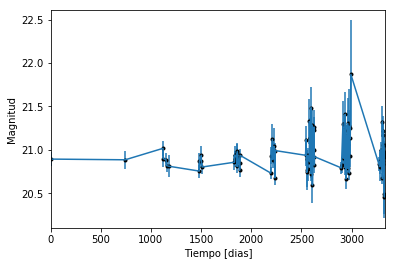

In [2]:
data = np.genfromtxt('LC_U_32769.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')

In [3]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [4]:
%%capture capt
sample = model.run_mcmc(20000)

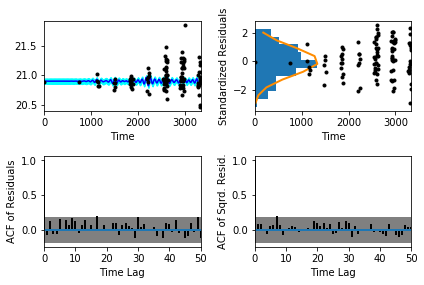

In [5]:
sample.assess_fit()

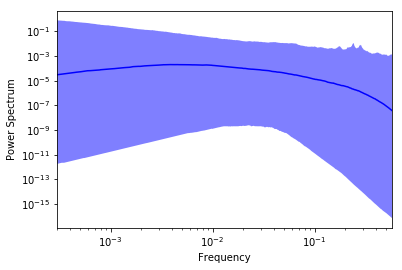

In [6]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)

NameError: name 'noise_level' is not defined

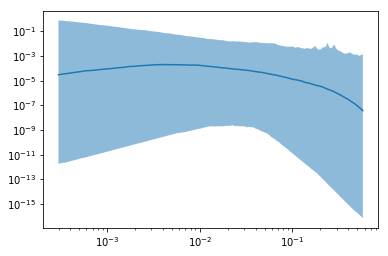

In [7]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Espectro de potencia')
plt.xlabel('Frecuencia  [1 / dia]')
plt.annotate("Nivel de ruido", (1.25* plt.xlim()[0], noise_level / 1.5))

Text(0.5,1,'Prediccion , valor esperado ')

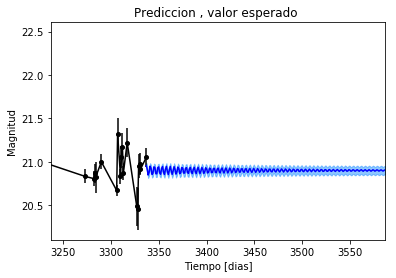

In [8]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')
plt.title('Prediccion , valor esperado ')

Text(0.5,1,'Prediccion, Caminos simulados')

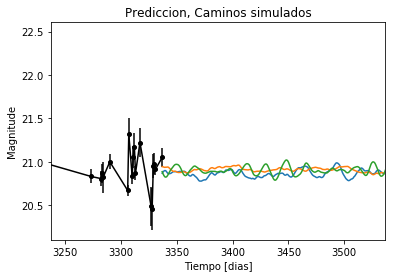

In [9]:
tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 3
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Prediccion, Caminos simulados')

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


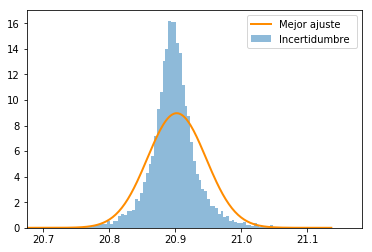

In [10]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Incertidumbre ')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Mejor ajuste ')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolacion, camino simulado')

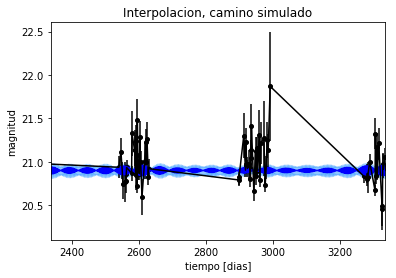

In [11]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
ypredict, yp_var = sample.predict(tinterp)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tinterp, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tinterp, ypredict, 'b-')
plt.xlabel('tiempo [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Text(0.5,1,'Interpolacion, camino simulado')

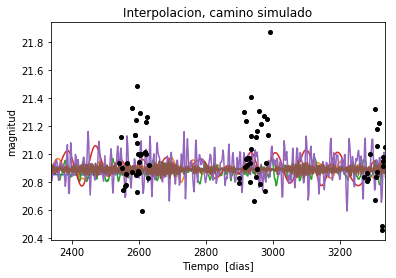

In [12]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 6
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Tiempo  [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Plotting parameter summary


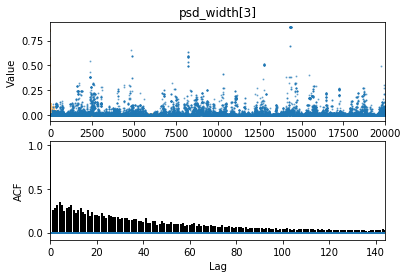

In [13]:
sample.plot_parameter('psd_width', 3, doShow=True)

In [14]:
centroid_samples = sample.get_samples('logpost')
centroid_samples.shape

(20000, 1)

In [15]:
sample.posterior_summaries('logpost')

Calculating effective number of samples
Posterior summary for parameter logpost  element 0
----------------------------------------------
Effective number of independent samples: 2104.07826459
Median: 122.929120831
Standard deviation: 1.29367861467
68% credibility interval: [ 121.50499411  123.73307847]
95% credibility interval: [ 119.3589095   124.51761044]
99% credibility interval: [ 117.5970364   125.22677734]


In [16]:
centroid_samples = sample.get_samples('ar_coefs')
centroid_samples.shape

(20000, 5)

In [17]:
sample.posterior_summaries('ar_coefs')

Calculating effective number of samples
Posterior summary for parameter ar_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ar_coefs  element 1
----------------------------------------------
Effective number of independent samples: 833.288894667
Median: 0.807820398104
Standard deviation: 2.34527786413
68% credibility interval: [ 0.08667397  3.92146182]
95% credibility interval: [ 0.01719152  8.13780606]
99% credibility interval: [  1.12739508e-02   1.22707391e+01]
Posterior summary for parameter ar_coefs  element 2
----------------------------------------------
Effective number of independent samples: 555.14068727
Median: 3.8287547706
Standard deviation: 15.6269111996
68% credibility interval: [  0.23105374  26.62912176]
95% credibility interval: [  9.66

In [18]:
centroid_samples = sample.get_samples('ma_coefs')
centroid_samples.shape

(20000, 2)

In [19]:
sample.posterior_summaries('ma_coefs')

Calculating effective number of samples
Posterior summary for parameter ma_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ma_coefs  element 1
----------------------------------------------
Effective number of independent samples: 883.871244743
Median: 1.96720059327e+12
Standard deviation: 7.5150227523e+135
68% credibility interval: [  2.20494543e-46   3.59090753e+63]
95% credibility interval: [  4.28130954e-134   1.06071708e+133]
99% credibility interval: [  3.49283306e-141   3.28996385e+135]


In [20]:
centroid_samples = sample.get_samples('mu')
centroid_samples.shape

(20000, 1)

In [21]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [22]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 1363.17304814
Median: 0.240025647189
Standard deviation: 0.321997631847
68% credibility interval: [ 0.01525486  0.73690002]
95% credibility interval: [ 0.          1.06128974]
99% credibility interval: [ 0.          1.12054325]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 1363.17304814
Median: 0.240025647189
Standard deviation: 0.321997631847
68% credibility interval: [ 0.01525486  0.73690002]
95% credibility interval: [ 0.          1.06128974]
99% credibility interval: [ 0.          1.12054325]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 416.244808715
Median: 0.00190542867747
Standard deviation: 0.15011705436

In [23]:
centroid_samples = sample.get_samples('loglik')
centroid_samples.shape

(20000, 1)

In [24]:
sample.posterior_summaries('loglik')

Calculating effective number of samples
Posterior summary for parameter loglik  element 0
----------------------------------------------
Effective number of independent samples: 2104.07826459
Median: 122.929120831
Standard deviation: 1.29367861467
68% credibility interval: [ 121.50499411  123.73307847]
95% credibility interval: [ 119.3589095   124.51761044]
99% credibility interval: [ 117.5970364   125.22677734]


In [25]:
centroid_samples = sample.get_samples('psd_width')
centroid_samples.shape

(20000, 4)

In [26]:
sample.posterior_summaries('psd_width')

Calculating effective number of samples
Posterior summary for parameter psd_width  element 0
----------------------------------------------
Effective number of independent samples: 719.821728944
Median: 0.00839630391549
Standard deviation: 0.159772066532
68% credibility interval: [ 0.0009208   0.11131877]
95% credibility interval: [  3.60929685e-04   6.17736192e-01]
99% credibility interval: [  3.04366104e-04   9.60321548e-01]
Posterior summary for parameter psd_width  element 1
----------------------------------------------
Effective number of independent samples: 403.662964862
Median: 0.00598585096935
Standard deviation: 0.111177770049
68% credibility interval: [ 0.00082098  0.06873013]
95% credibility interval: [  3.49008037e-04   3.66320958e-01]
99% credibility interval: [  3.03551107e-04   8.02802048e-01]
Posterior summary for parameter psd_width  element 2
----------------------------------------------
Effective number of independent samples: 1308.6263841
Median: 0.0215842651557


In [27]:
centroid_samples = sample.get_samples('var')
centroid_samples.shape

(20000, 1)

In [28]:
sample.posterior_summaries('var')

Calculating effective number of samples
Posterior summary for parameter var  element 0
----------------------------------------------
Effective number of independent samples: 1788.94934519
Median: 0.000685836645213
Standard deviation: 0.00156028789514
68% credibility interval: [  7.03041613e-05   2.35618602e-03]
95% credibility interval: [  1.81179159e-06   5.38848553e-03]
99% credibility interval: [  2.43789422e-08   8.64619215e-03]


In [29]:
centroid_samples = sample.get_samples('measerr_scale')
centroid_samples.shape

(20000, 1)

In [30]:
sample.posterior_summaries('measerr_scale')

Calculating effective number of samples
Posterior summary for parameter measerr_scale  element 0
----------------------------------------------
Effective number of independent samples: 2673.4144142
Median: 1.36839128426
Standard deviation: 0.167904287838
68% credibility interval: [ 1.20829784  1.54025871]
95% credibility interval: [ 1.07142932  1.73597939]
99% credibility interval: [ 0.98314237  1.85048466]


In [31]:
centroid_samples = sample.get_samples('sigma')
centroid_samples.shape

(20000, 1)

In [32]:
sample.posterior_summaries('sigma')

Calculating effective number of samples
Posterior summary for parameter sigma  element 0
----------------------------------------------
Effective number of independent samples: 1043.8047059
Median: 2.5342032948e-15
Standard deviation: 0.453293291964
68% credibility interval: [  1.03806603e-66   1.42877921e-02]
95% credibility interval: [  7.66975244e-136   7.85335062e-001]
99% credibility interval: [  1.17697451e-138   2.85120423e+000]


In [33]:
centroid_samples = sample.get_samples('ar_roots')
centroid_samples.shape

(20000, 4)

In [34]:
sample.posterior_summaries('ar_roots')

Calculating effective number of samples
Posterior summary for parameter ar_roots  element 0
----------------------------------------------
Effective number of independent samples: 719.821728944
Median: (-0.0527555333964-2.04003002755j)
Standard deviation: 2.25853715485
68% credibility interval: [-0.69943647-4.67798614j -0.00578559-0.57055912j]
95% credibility interval: [ -3.88135097e+00-0.1485557j  -2.26778810e-03-0.4459651j]
99% credibility interval: [ -6.03387824e+00-3.34218376j  -1.91238864e-03-2.565672j  ]
Posterior summary for parameter ar_roots  element 1
----------------------------------------------
Effective number of independent samples: 403.662964862
Median: (-0.0376102108616+1.36009639567j)
Standard deviation: 2.14037213766
68% credibility interval: [-0.43184415+2.1846215j  -0.00515836+0.10800645j]
95% credibility interval: [ -2.30166246e+00+6.45133716j  -2.19288217e-03+1.09162305j]
99% credibility interval: [ -5.04415403e+00+4.00568541j  -1.90726785e-03+0.j        ]
Poster

Plotting 2d PDF w KDE


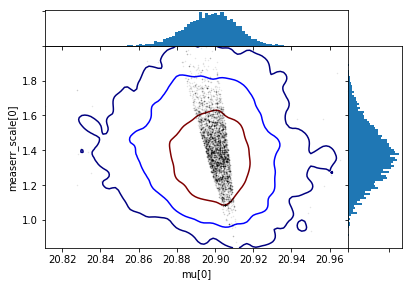

In [35]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


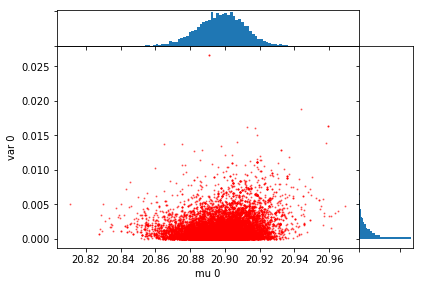

In [36]:
sample.plot_2dpdf('mu', 'var', doShow=True)

Plotting 2d PDF w KDE


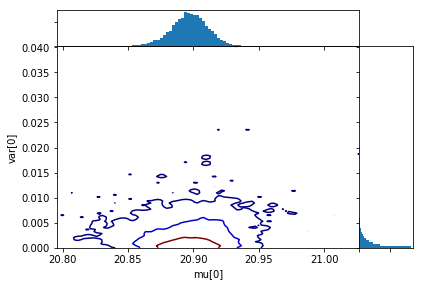

In [38]:
sample.plot_2dkde('mu', 'var', doShow=True)